# Importing packages

In [2]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.patches as mpatches

import os
import re
import math
from tqdm import tqdm
from itertools import compress
import scipy.integrate as integrate
from scipy.stats import geom
import scipy
import string
import seaborn as sns

import pickle

In [3]:
# Import Plotly Packages
import plotly.express as px
import plotly.offline as py     
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio

# retina
%config InlineBackend.figure_format = 'retina'

# Checking path

In [4]:
!pwd

/Users/jerrylin/Desktop/OfflineWork/spreadtesting_analysis_new


# Load in precomputed data

In [5]:
# Lagged error

laggedTemp = np.array([1.24597422, 1.20808864, 0.95651954, 1.10964614, 1.15747504,
       1.20006439, 1.20698342, 1.08681107, 1.11792952, 1.1810788 ,
       1.12424296, 1.00378561])
laggedHum = np.array([0.0004288 , 0.00050264, 0.0004187 , 0.00044926, 0.00045721,
       0.00051713, 0.00043587, 0.00038312, 0.00041855, 0.00043176,
       0.00044012, 0.0003916])

# Online error

load_path = './pkl_files_new/'

with open(load_path + 'prognostic_runs.pkl', 'rb') as f:
    family_dict = pickle.load(f)

with open(load_path + 'offline_data.pkl', 'rb') as f:
    pd_dict = pickle.load(f)
    
with open(load_path + 'bootstrap_dfs.pkl', 'rb') as f:
    bootstrap_dict = pickle.load(f)
    
with open(load_path + 'bootstrap_counts.pkl', 'rb') as f:
    counts_bootstrap_dict = pickle.load(f)
    
with open(load_path + 'bootstrap_temp.pkl', 'rb') as f:
    boot_temp_dict = pickle.load(f)

with open(load_path + 'bootstrap_hum.pkl', 'rb') as f:
    boot_hum_dict = pickle.load(f)

# Offline error strato

offline_strato_path = '/Users/jerrylin/Desktop/OfflineWork/spreadtesting_analysis_new/offline_errors_strato/'

with open(offline_strato_path + 'specific' + '/rmse_strato.npy', 'rb') as f:
    offline_error_strato_specific = np.load(f)

with open(offline_strato_path + 'relative' + '/rmse_strato.npy', 'rb') as f:
    offline_error_strato_relative = np.load(f)

with open(offline_strato_path + 'expanded' + '/rmse_strato.npy', 'rb') as f:
    offline_error_strato_expanded = np.load(f)

with open(offline_strato_path + 'previous' + '/rmse_strato.npy', 'rb') as f:
    offline_error_strato_previous = np.load(f)

with open(offline_strato_path + 'split' + '/rmse_strato.npy', 'rb') as f:
    offline_error_strato_split = np.load(f)

# Offline error

offline_path = '/Users/jerrylin/Desktop/OfflineWork/spreadtesting_analysis_new/offline_errors/'

with open(offline_path + 'specific' + '/rmse.npy', 'rb') as f:
    offline_error_specific = np.load(f)

with open(offline_path + 'relative' + '/rmse.npy', 'rb') as f:
    offline_error_relative = np.load(f)

with open(offline_path + 'expanded' + '/rmse.npy', 'rb') as f:
    offline_error_expanded = np.load(f)

with open(offline_path + 'previous' + '/rmse.npy', 'rb') as f:
    offline_error_previous = np.load(f)

with open(offline_path + 'split' + '/rmse.npy', 'rb') as f:
    offline_error_split = np.load(f)

# Linear regression baselines

offline_mlr_error_strato_T = 4.2002143014136987e-05
offline_mlr_error_strato_Q = 2.696047033913751e-08

offline_mlr_error_T = 4.616455168329758e-05
offline_mlr_error_Q = 2.982390230573105e-08

# Naming

family_labels = {"specific":"specific humidity (SH)",\
                 "relative":"relative humidity (RH)",\
                 "expanded":"expanded variables (EV)",\
                 "previousTendencies":"previous tendencies (PT)",\
                 "split":"split networks (SN)"}

family_colors = {"specific":"blue",\
                 "relative":"red",\
                 "expanded":"mediumturquoise",\
                 "previousTendencies":"purple",\
                 "split":"orange"}

family_fades = {"specific":"Blues",\
                 "relative":"Reds",\
                 "expanded": "BuGn",\
                 "previousTendencies":"Purples",\
                 "split":"Oranges"}

# Creating plotting functions

In [6]:
%config InlineBackend.figure_format = 'retina'
letters = string.ascii_lowercase
plt.rcParams['font.size'] = 12
myfontsize = 12

In [7]:
def peek(family, number, var):
    folder = "/ocean/projects/atm200007p/jlin96/new_final_families/nnSpreadTesting_" + family + "/coupled_results/"
    path = folder + family + "_model_%03d"%number + "/"
    h1List = os.popen(" ".join(["ls", path + "*.h1.0000*"])).read().splitlines()
    dataset = xr.open_mfdataset(h1List)
    if var == "NNTBP":
        arr = dataset["NNTBP"]
    elif var == "NNQBP":
        arr = dataset["NNQBP"]
    return arr

def getDiff(family, number, var):
    arr = peek(family, number, var)
    endLength = np.arange(1,13)[arr.shape[0]>=month_sum_days][-1] #such that only complete months are added
    arr = np.array(arr.groupby("time.month").mean("time"))
    if var == "NNTBP":
        sp_vals = sp_temp[:endLength,12:30,:,:]
    elif var == "NNQBP":
        sp_vals = sp_hum[:endLength,12:30,:,:]
    se = (sp_vals-arr[:endLength,12:30,:,:])**2
    wse = error_weights*se
    return np.sum(wse, axis = (1,2,3))**.5

def monthcheck(family, number, var):
    arr = peek(family, number, var)
    if arr.shape[0] < 31:
        return False
    return True

def load_run(family, var, num_runs = 330):
    diff_var = []
    plotted_var = []
    for i in tqdm(range(num_runs)):
        modelrank = i+1
        if monthcheck(family, modelrank, var):
            diff = getDiff(family, modelrank, var)
            diff_var.append(diff)
            plotted_var.append(True)
        else:
            plotted_var.append(False)
    return diff_var, plotted_var

def plotDiffs(axnum, families, var, custom = [], logy = True, show_legend = True):
    colors = [family_colors["specific"], \
              family_colors["relative"], \
              family_colors["expanded"], \
              family_colors["previousTendencies"], \
              family_colors["split"]]
    for i in range(len(families)):   
        for j in range(len(families[i])):
            axnum.plot(np.arange(len(families[i][j]))+1, families[i][j], color = colors[i], linewidth = .25)
    if var == "NNTBP":
        var_label = "Temperature"
        axnum.plot(np.arange(12)+1, laggedTemp, color = "black", linewidth = .8)
    if var == "NNQBP":
        var_label = "Humidity"
        axnum.plot(np.arange(12)+1, laggedHum, color = "black", linewidth = .8)
    
    colors.append("black")
    custom.append("internal variability proxy")
    
    patches = [mpatches.Patch(facecolor = x) for x in colors]
    if show_legend:
        axnum.legend(handles = patches, \
                labels = custom, \
                loc = "upper right", \
                borderaxespad = 0.1, \
                fontsize = 10)
    axnum.set_title("Online Monthly " + var_label + " RMSE")
    if logy:
        axnum.set_yscale("log")
    
    axnum.set_xlabel("month")
    if var == "NNTBP":
        axnum.set_ylabel("K")
    if var == "NNQBP":
        axnum.set_ylabel("kg/kg")
        
def plot_single_diffs(axnum, families, var, custom = [], logy = True):
    colors = ["blue", "red", "green", "purple", "orange"]
    for i in range(len(families)):   
        axnum.plot(families[i], color = colors[i], linewidth = .25)
    if var == "NNTBP":
        var_label = "Temperature"
        axnum.plot(laggedTemp, color = "black", linewidth = .8)
    if var == "NNQBP":
        var_label = "Humidity"
        axnum.plot(laggedHum, color = "black", linewidth = .8)
    
    colors.append("black")
    custom.append("IV proxy")
    
    patches = [mpatches.Patch(facecolor = x) for x in colors]

    axnum.legend(handles = patches, \
            labels = custom, \
            loc = "upper right", \
            borderaxespad = 0.1, \
            fontsize = 8)
    axnum.set_title(var_label + " Root Mean Squared Error (RMSE)")
    if logy:
        axnum.set_yscale("log")
    
    axnum.set_xlabel("month")
    if var == "NNTBP":
        axnum.set_ylabel("K")
    if var == "NNQBP":
        axnum.set_ylabel("kg/kg")
        
def plot_marginal_runs(family, var, diff_runs, plotted_runs, hyperparameter, color_gradient, log_sampled = False, num_runs = 330, limits = [], custom = []):
    proj_dir = "/ocean/projects/atm200007p/jlin96/nnSpreadTesting_"
    model_num = np.array(range(num_runs))
    rank_plotted = model_num[plotted_runs]
    pd_proj = pd.read_pickle(proj_dir + family + "/coupling_folder/" + "RESULTS_" + family + ".pandas.pkl")
    summary = {family:pd_proj}
    marginal = {i:pd_proj.iloc[i][hyperparameter] for i in rank_plotted}
    marginal = np.array(list(marginal.values()))
    num_values = len(pd_proj[hyperparameter].unique())
    if log_sampled:
        marginal = np.log10(marginal)
    if num_values > 5:
        fig, ax = plt.subplots(nrows = 1, ncols = 2, gridspec_kw={'width_ratios': [6, .3]})
        axnum = ax[0]
        axbar = ax[1]
        cmap = mpl.colormaps[color_gradient]
        if len(limits) == 0:
            limits = []
            limits.append(math.floor(min(marginal)))
            limits.append(math.ceil(max(marginal)))
        print(limits)
        print(pd_proj[hyperparameter])
        shift = limits[0]
        scale = limits[1] - shift
        marginal_scaled = (marginal - shift)/scale
        for i in range(len(diff_runs)):
            axnum.plot(diff_runs[i], color = cmap(marginal_scaled[i]))
        if var == "NNTBP":
            axnum.plot(laggedTemp, color = "black")
        if var == "NNQBP":
            axnum.plot(laggedHum, color = "black")
        black_patch = mpatches.Patch(facecolor='black')
        axnum.legend(handles = [black_patch], \
                   labels=["IV proxy"], \
                   loc="upper right", \
                   borderaxespad=0.1)
        axnum.set_yscale("log")
        if len(custom)==0:
            if log_sampled:
                ylabel = "log of " + hyperparameter
            else:
                ylabel = hyperparameter
            axnum.set_title(family + " " + var + " RMSE")
        else:
            if log_sampled:
                ylabel = "log of " + custom[1]
            else:
                ylabel = custom[1]
            axnum.set_title(custom[0])            
        axnum.set_xlabel("month")
        if var == "NNTBP":
            axnum.set_ylabel("K")
        if var == "NNQBP":
            axnum.set_ylabel("kg/kg")
        norm = mpl.colors.Normalize(vmin=limits[0], vmax=limits[1])
        fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), cax=axbar, orientation='vertical', label=ylabel)
    else:
        colors_d = ["blue", "orange", "green", "red", "purple"]
        hp_choices = pd_proj[hyperparameter].unique()
        d_map = {hp_choices[i]: colors_d[i] for i in range(len(hp_choices))}
        for i in range(len(diff_runs)):
            plt.plot(diff_runs[i], color = d_map[marginal[i]])
        if var == "NNTBP":
            plt.plot(laggedTemp, color = "black")
        if var == "NNQBP":
            plt.plot(laggedHum, color = "black")
        total_handles = []
        total_labels = []
        for key in d_map:   
            total_handles.append(mpatches.Patch(facecolor=d_map[key]))
            total_labels.append(key)
        total_handles.append(mpatches.Patch(facecolor='black'))
        total_labels.append("IV proxy")
        plt.legend(handles = total_handles, \
                   labels = total_labels, \
                   loc="upper right", \
                   borderaxespad=0.1)
        if len(custom)==0:
            plt.title(family + " " + var + " RMSE (" + hyperparameter + ")")
        else:
            plt.title(custom[0])
        plt.yscale("log")
        plt.xlabel("month")
        if var == "NNTBP":
            plt.ylabel("K")
        if var == "NNQBP":
            plt.ylabel("kg/kg")
            
            
def scatter_marginal_runs(family, var, diff_runs, plotted_runs, hyperparameter, color_gradient, log_sampled = False, num_runs = 330, limits = [],\
                         axlims = [], custom = []):
    proj_dir = "/ocean/projects/atm200007p/jlin96/new_final_families/nnSpreadTesting_"
    model_num = np.array(range(num_runs))+1
    rank_plotted = model_num[plotted_runs]
    pd_proj = pd.read_pickle(proj_dir + family + "/coupling_folder/" + "RESULTS_" + family + ".pandas.pkl")
    pd_proj["total_hidden_nodes"] = pd_proj["hidden_units"]*pd_proj["num_layers"]
    summary = {family:pd_proj}
    marginal = {i:pd_proj.loc[i][hyperparameter] for i in rank_plotted}
    marginal = np.array(list(marginal.values()))
    num_values = len(pd_proj[hyperparameter].unique())
    
    duration = np.array([len(arr) for arr in diff_runs])
    avgerr = np.array([np.mean(arr) for arr in diff_runs])
    
    if log_sampled:
        marginal = np.log10(marginal)
    if num_values > 5:
        fig, ax = plt.subplots(nrows = 1, ncols = 2, gridspec_kw={'width_ratios': [6, .3]})
        axnum = ax[0]
        axbar = ax[1]
        cmap = mpl.colormaps[color_gradient]
        if len(limits) == 0:
            limits = []
            limits.append(math.floor(min(marginal)))
            limits.append(math.ceil(max(marginal)))

        shift = limits[0]
        scale = limits[1] - shift
        marginal_scaled = (marginal - shift)/scale
        for i in range(len(diff_runs)):
            axnum.scatter(marginal[i], avgerr[i], color = cmap(duration[i]/12))
        
        axnum.set_yscale("log")
        
        if len(axlims)!=0:
            axnum.set_xlim(axlims[0],axlims[1])
            
        ylabel = "proportion of simulation year integrated"
        if len(custom)==0:
            axnum.set_title(family + " " + var + " average RMSE")
            axnum.set_xlabel(hyperparameter + " value")
        else:
            axnum.set_title(custom[0])
            axnum.set_xlabel(custom[1])        
        if var == "NNTBP":
            axnum.set_ylabel("K")
        if var == "NNQBP":
            axnum.set_ylabel("kg/kg")
        
        norm = mpl.colors.Normalize(vmin=0, vmax=1)
        fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), cax=axbar, orientation='vertical', label=ylabel)
    else:
        colors_d = ["blue", "orange", "green", "red", "purple"]
        hp_choices = pd_proj[hyperparameter].unique()
        d_map = {hp_choices[i]: colors_d[i] for i in range(len(hp_choices))}
        for i in range(len(diff_runs)):
            plt.scatter(duration[i], avgerr[i], color = d_map[marginal[i]])
        total_handles = []
        total_labels = []
        for key in d_map:   
            total_handles.append(mpatches.Patch(facecolor=d_map[key]))
            total_labels.append(key)
        plt.legend(handles = total_handles, \
                   labels = total_labels, \
                   loc="upper right", \
                   borderaxespad=0.1)
        plt.title(family + " " + var + " averaged RMSE (" + hyperparameter + ")")
        plt.xlabel("final month of simulation")
        if var == "NNTBP":
            plt.ylabel("K")
        if var == "NNQBP":
            plt.ylabel("kg/kg")

def showpandas(family, num_runs = 330):
    proj_dir = "/ocean/projects/atm200007p/jlin96/new_final_families/nnSpreadTesting_"
    test_dir = proj_dir + family + "/offlinetesteval/offline_errors/"
    with open(test_dir + "rmse.npy", 'rb') as f:
        rmse = np.load(f)
    model_num = np.array(range(num_runs))+1
    pd_proj = pd.read_pickle(proj_dir + family + "/coupling_folder/" + "RESULTS_" + family + ".pandas.pkl")
    if family != "split":
        pd_proj["total_hidden_nodes"] = pd_proj["hidden_units"]*pd_proj["num_layers"]
    else:
        pd_proj["total_hidden_nodes"] = pd_proj["hidden_units_TPHYSTND"]*pd_proj["num_layers_TPHYSTND"] + \
                                        pd_proj["hidden_units_PHQ"]*pd_proj["num_layers_PHQ"]
    offline_rmse = pd.DataFrame(rmse, columns = ["offline_rmse_T", "offline_rmse_Q"], index = pd_proj.index)
    pd_proj = pd.concat([pd_proj, offline_rmse], axis = 1)
    return pd_proj

def make_diff_mseh(diff_T, diff_Q):
    assert(len(diff_T)==len(diff_Q))
    diff_mseh = []
    for i in range(len(diff_T)):
        diff_mseh.append(cp*diff_T[i] + lv*diff_Q[i]/(1-diff_Q[i]))
    return diff_mseh

def make_nps(diff_mseh, plotted):
    mseh_max = [max(x) for x in diff_mseh]
    mseh_len = [len(x) for x in diff_mseh]
    nps = []
    count = 0
    for i in plotted:
        if not i:
            nps.append(0)
        else:
            nps.append(mseh_len[count]/mseh_max[count])
            count += 1
    return np.array(nps)

def make_month_count(diff, plotted):
    diff_len = [len(x) for x in diff]
    runlens = []
    count = 0
    for i in plotted:
        if not i:
            runlens.append(0)
        else:
            runlens.append(diff_len[count])
            count += 1
    return np.array(runlens)

def plotModel(nums, diffs_T, diffs_Q, plotbools_T, plotbools_Q, label, logy = False):
    
    new_diff_T = []
    new_diff_Q = []
    
    for num in nums:
        new_diff_T.append(diffs_T[sum(plotbools_T[0:num])-1])
        new_diff_Q.append(diffs_Q[sum(plotbools_Q[0:num])-1])
    
    fig, ax = plt.subplots(nrows=1, ncols=2)

    ax1 = ax[0]
    ax2 = ax[1]

    plotDiffs(ax1, [new_diff_T], "NNTBP", \
              [label + "nodel number " + str(num)], logy)

    plotDiffs(ax2, [new_diff_Q], "NNQBP", \
              [label + "model number " + str(num)], logy)

    plt.subplots_adjust(0,0,2,1)
    
    return

def scatter_hyperparameter(family, hyperparameter, xlabel = "", num_runs = 330, log_sampled = False, axlims = []):
    proj_dir = "/ocean/projects/atm200007p/jlin96/new_final_families/nnSpreadTesting_"
    model_num = np.array(range(num_runs))+1
    
    fig, ax = plt.subplots(nrows = 1, ncols = 5, gridspec_kw={'width_ratios': [6, .3, 1, 6, .3]})
    
    axnum_T = ax[0]
    axbar_T = ax[1]
    ax[2].axis('off')
    axnum_Q = ax[3]
    axbar_Q = ax[4]
    
    axnum_T.set_yscale("log")
    axnum_Q.set_yscale("log")

    axnum_T.set_ylabel("average online temperature RMSE (K)")
    axnum_Q.set_ylabel("average online humidity RMSE (kg/kg)")
        
    cmap_T = mpl.colormaps[family_fades[family]]
    cmap_Q = mpl.colormaps[family_fades[family]]
    
    diff_runs_T = family_dict[family][0]
    diff_runs_Q = family_dict[family][2]
    
    plotted_runs_T = family_dict[family][1]
    plotted_runs_Q = family_dict[family][3]
    
    rank_plotted_T = model_num[plotted_runs_T]
    rank_plotted_Q = model_num[plotted_runs_Q]
    
    assert(sum(rank_plotted_T!=rank_plotted_Q)==0)
    rank_plotted = rank_plotted_T

    pd_proj = pd_dict[family]
    summary = {family:pd_proj}
    
    marginal_T = {i:pd_proj.loc[i][hyperparameter] for i in rank_plotted}
    marginal_T = np.array(list(marginal_T.values()))
    marginal_Q = {i:pd_proj.loc[i][hyperparameter] for i in rank_plotted}
    marginal_Q = np.array(list(marginal_Q.values()))
    
    if log_sampled:
        marginal_T = np.log10(marginal_T)
        marginal_Q = np.log10(marginal_Q)
    
    duration_T = np.array([len(arr) for arr in diff_runs_T])
    duration_Q = np.array([len(arr) for arr in diff_runs_Q])
    
    avgerr_T = np.array([np.mean(arr) for arr in diff_runs_T])
    avgerr_Q = np.array([np.mean(arr) for arr in diff_runs_Q])

    for i in range(len(diff_runs_T)):
        axnum_T.scatter(marginal_T[i], avgerr_T[i], color = cmap_T(duration_T[i]/12))
    
    for i in range(len(diff_runs_Q)):
        axnum_Q.scatter(marginal_Q[i], avgerr_Q[i], color = cmap_Q(duration_Q[i]/12))
    
    axnum_T.set_title("online temperature RMSE")
    axnum_Q.set_title("online humidity RMSE")
    
    axnum_T.set_xlabel(xlabel)
    axnum_Q.set_xlabel(xlabel)
    if len(axlims)!=0:
        axnum_T.set_xlim(axlims[0][0], axlims[0][1])
        axnum_Q.set_xlim(axlims[1][0], axlims[1][1])
        axnum_T.set_ylim(axlims[2][0], axlims[2][1])
        axnum_Q.set_ylim(axlims[3][0], axlims[3][1])
     
    norm = mpl.colors.Normalize(vmin=0, vmax=1)
    ylabel = "Survival Time Ratio"
    fig.colorbar(mpl.cm.ScalarMappable(norm = norm, cmap=family_fades[family]), cax = axbar_T, orientation='vertical')
    fig.colorbar(mpl.cm.ScalarMappable(norm = norm, cmap=family_fades[family]), cax = axbar_Q, orientation='vertical', label=ylabel)
    #
    
    plt.subplots_adjust(wspace=.24)
    fig.set_size_inches(14,5)
    plt.suptitle(family_labels[family] + ' family')
    return

def scatter_offlinevonline(family, num_runs = 330, axlims_Tx = [], axlims_Ty = [], axlims_Qx = [], axlims_Qy = []):
    proj_dir = "/ocean/projects/atm200007p/jlin96/new_final_families/nnSpreadTesting_"
    model_num = np.array(range(num_runs))+1
    
    fig, ax = plt.subplots(nrows = 1, ncols = 5, gridspec_kw={'width_ratios': [6, .3, 1, 6, .3]})
    
    axnum_T = ax[0]
    axbar_T = ax[1]
    ax[2].axis('off')
    axnum_Q = ax[3]
    axbar_Q = ax[4]
    
    axnum_T.set_xlim(axlims_Tx[0], axlims_Tx[1])
    axnum_Q.set_xlim(axlims_Qx[0], axlims_Qx[1])
    
    axnum_T.set_ylim(axlims_Ty[0], axlims_Ty[1])
    axnum_Q.set_ylim(axlims_Qy[0], axlims_Qy[1])
    
    axnum_T.set_yscale("log")
    axnum_Q.set_yscale("log")

    axnum_T.set_ylabel("average online temperature RMSE (K)")
    axnum_Q.set_ylabel("average online humidity RMSE (kg/kg)")
        
    cmap_T = mpl.colormaps[family_fades[family]]
    cmap_Q = mpl.colormaps[family_fades[family]]
    
    diff_runs_T = family_dict[family][0]
    diff_runs_Q = family_dict[family][2]
    
    plotted_runs_T = family_dict[family][1]
    plotted_runs_Q = family_dict[family][3]
    
    rank_plotted_T = model_num[plotted_runs_T]
    rank_plotted_Q = model_num[plotted_runs_Q]
    
    assert(sum(rank_plotted_T!=rank_plotted_Q)==0)
    rank_plotted = rank_plotted_T

    pd_proj = pd_dict[family]
    summary = {family:pd_proj}
    
    marginal_T = {i:pd_proj.loc[i]["offline_rmse_strato_T"] for i in rank_plotted}
    marginal_T = np.array(list(marginal_T.values()))
    marginal_Q = {i:pd_proj.loc[i]["offline_rmse_strato_Q"] for i in rank_plotted}
    marginal_Q = np.array(list(marginal_Q.values()))
    
    duration_T = np.array([len(arr) for arr in diff_runs_T])
    duration_Q = np.array([len(arr) for arr in diff_runs_Q])
    
    avgerr_T = np.array([np.mean(arr) for arr in diff_runs_T])
    avgerr_Q = np.array([np.mean(arr) for arr in diff_runs_Q])
    
#     return marginal_T, marginal_Q

#     marginal_T = np.log10(marginal_T)
#     marginal_Q = np.log10(marginal_Q)

    for i in range(len(diff_runs_T)):
        axnum_T.scatter(marginal_T[i], avgerr_T[i], color = cmap_T(duration_T[i]/12))

    for i in range(len(diff_runs_Q)):
        axnum_Q.scatter(marginal_Q[i], avgerr_Q[i], color = cmap_Q(duration_Q[i]/12))
    
    axnum_T.set_title("temperature")
    axnum_Q.set_title("moisture")
    
    axnum_T.set_xlabel("offline heating RMSE (K/s)")
    axnum_Q.set_xlabel("offline moistening RMSE (kg/kg/s)")
     
    norm = mpl.colors.Normalize(vmin=0, vmax=1)
    ylabel = "Survival Time Ratio"
    fig.colorbar(mpl.cm.ScalarMappable(norm = norm, cmap=family_fades[family]), cax = axbar_T, orientation='vertical')
    fig.colorbar(mpl.cm.ScalarMappable(norm = norm, cmap=family_fades[family]), cax = axbar_Q, orientation='vertical', label=ylabel)
    #
    
    plt.subplots_adjust(wspace=.24)
    fig.set_size_inches(14,5)
    plt.suptitle(family_labels[family] + ' configuration')
    return

def dict_compare(d1, d2):
    if type(d1) != type(d2):
        return False
    if isinstance(d1, dict):
        if set(d1.keys()) != set(d2.keys()):
            return False
        for k in d1:
            if not dict_compare(d1[k], d2[k]):
                return False
    elif isinstance(d1, list) or isinstance(d1, np.ndarray):
        if len(d1) != len(d2):
            return False
        for i in range(len(d1)):
            if not dict_compare(d1[i], d2[i]):
                return False
    elif isinstance(d1, pd.DataFrame):
        return d1.equals(d2)
    else:
        return d1 == d2
    return True

def bootstrap(arr, n=1000):
    statnames = ['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max']
    df = pd.DataFrame(columns=statnames)
    for i in range(n):
        resampled = pd.Series(np.random.choice(arr, len(arr))).describe()
        new_row = dict()
        for name in statnames:
            new_row[name] = [resampled[name]]
        df = pd.concat([df, pd.DataFrame(new_row)], ignore_index=True)
    return df

def bootstrap_count(arr, n = 1000):
    statnames = ['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max']
    countnames = [str(x) for x in range(13)]
    df = pd.DataFrame(columns=statnames)
    for i in range(n):
        resampled = pd.Series(np.random.choice(arr, len(arr)))
        summary_stats = resampled.describe()
        for name in countnames:
            summary_stats[name] = sum(resampled==float(name))
        new_row = dict()
        colnames = statnames + countnames
        for name in colnames:
            new_row[name] = [summary_stats[name]]
        df = pd.concat([df, pd.DataFrame(new_row)], ignore_index=True)
    return df

def make_cis(df, var):
    specific_ci = (df[df["family"]=="specific"][var].quantile(.025), df[df["family"]=="specific"][var].quantile(.975))
    relative_ci = (df[df["family"]=="relative"][var].quantile(.025), df[df["family"]=="relative"][var].quantile(.975))
    expanded_ci = (df[df["family"]=="expanded"][var].quantile(.025), df[df["family"]=="expanded"][var].quantile(.975))
    previous_ci = (df[df["family"]=="previousTendencies"][var].quantile(.025), df[df["family"]=="previousTendencies"][var].quantile(.975))
    split_ci = (df[df["family"]=="split"][var].quantile(.025), df[df["family"]=="split"][var].quantile(.975))
    return([specific_ci, relative_ci, expanded_ci, previous_ci, split_ci])

def show_hps(family):
    scatter_hyperparameter(family, "leak", "Leaky ReLu slope")
    scatter_hyperparameter(family, "dropout", "dropout")
    scatter_hyperparameter(family, "lr", "log(learning rate)", log_sampled = True)
    scatter_hyperparameter(family, "num_layers", "# of hidden layers")
    scatter_hyperparameter(family, "hidden_units", "# of nodes per layer")
    scatter_hyperparameter(family, "total_hidden_nodes", "total # of hidden nodes")
    scatter_hyperparameter(family, "min_val_loss", "offline validation error", axlims = [[.001,.002],[.001,0.002],[0,1e2],[0,1e-2]])
    scatter_offlinevonline(family, axlims_Tx = [2e-5, 6e-5], axlims_Ty = [5e-1,1.8e2], axlims_Qx = [2e-8, 3.35e-8], axlims_Qy = [6e-4,2e-2])
    scatter_hyperparameter(family, "nps", "normalized prognostic stability", axlims = [[0,.0025],[0,.0025],[0,1e2],[0,1e-2]])
    scatter_hyperparameter(family, "months_ran", "months ran")

    fig_batchnorm = px.histogram(data_frame = pd_dict[family], x = ["nps"], color = "batch_normalization", \
                                 histnorm = "percent", marginal = "rug", barmode='overlay')

    fig_batchnorm.update_layout(
        xaxis = dict(title= "normalized prognostic stability (" + family_labels[family] + " family)"),
        yaxis = dict(title = "percent"),
        font = dict(size = 15)
    )

    fig_batchnorm.update_layout(
        font = dict(size = 14))

    fig_batchnorm.show()

    fig_optimizer = px.histogram(data_frame = pd_dict[family], x = ["nps"], color = "optimizer", \
                                 histnorm = "percent", marginal = "rug", barmode='overlay')

    fig_optimizer.update_layout(
        xaxis = dict(title= "normalized prognostic stability (" + family_labels[family] + " family)"),
        yaxis = dict(title = "percent"),
        font = dict(size = 15)
    )

    fig_optimizer.update_layout(
        font = dict(size = 14))

    fig_optimizer.show()

def create_online_error_column(bool_list, array_list):
    new_list = [] # Empty list to store the new values
    array_index = 0 # Counter for indexing the array list

    for bool_val in bool_list:
        if bool_val and array_index < len(array_list):
            new_list.append(np.mean(array_list[array_index]))
            array_index += 1
        else:
            new_list.append(np.nan)
    return new_list

def plot2Dboxplot(arr_x, arr_y, ax, var, color):
    # Define the rectangle coordinates and size
    summary_x = arr_x.describe()
    summary_y = arr_y.describe()
    median_x = summary_x["50%"]
    median_y = summary_y["50%"]
    q1_x = summary_x["25%"]
    q3_x = summary_x["75%"]
    iqr_x = q3_x - q1_x
    q1_y = summary_y["25%"]
    q3_y = summary_y["75%"]
    iqr_y = q3_y - q1_y
    width, height = iqr_x, iqr_y
    x, y = median_x - width / 2, median_y - height / 2
    outliers_xx = arr_x[(arr_x < q1_x - 1.5*iqr_x) | (arr_x > q3_x + 1.5*iqr_x)]
    outliers_xy = arr_y[(arr_x < q1_x - 1.5*iqr_x) | (arr_x > q3_x + 1.5*iqr_x)]
    outliers_yx = arr_x[(arr_y < q1_y - 1.5*iqr_y) | (arr_y > q3_y + 1.5*iqr_y)]
    outliers_yy = arr_y[(arr_y < q1_y - 1.5*iqr_y) | (arr_y > q3_y + 1.5*iqr_y)]
    # Create a rectangle patch with a shading
    rect = mpatches.Rectangle((x, y), width, height, facecolor=color, edgecolor=color, linewidth=2, alpha=0.3)
    # Plot the rectangle and shading

    ax.add_patch(rect)
    if var == "T":
        leftlim, rightlim = 2e-5, 6e-5
        bottomlim, toplim = 5e-1, 1.8e2
        ax.set_xlabel("offline heating test RMSE (K/s)")
        ax.set_ylabel("average online temperature RMSE (K)")
    elif var == "Q":
        leftlim, rightlim = 2e-8, 3.35e-8
        bottomlim, toplim = 3e-4, 2e-2
        ax.set_xlabel("offline moistening test RMSE (kg/kg/s)")
        ax.set_ylabel("average online humidity RMSE (kg/kg)")
    ax.set_yscale('log')
    ax.set_xlim(leftlim,rightlim)
    ax.set_ylim(bottomlim,toplim)

    middle_y = y + height / 2
    middle_x = x + width / 2
    
    endline_left = q1_x - 1.5*iqr_x
    if endline_left < summary_x["min"]:
        endline_left = summary_x["min"]
    endline_right = q3_x + 1.5*iqr_x
    if endline_right > summary_x["max"]:
        endline_right = summary_x["max"]
    endline_bottom = q1_y - 1.5*iqr_y
    if endline_bottom < summary_y["min"]:
        endline_bottom = summary_y["min"]
    endline_top = q3_y + 1.5*iqr_y
    if endline_top > summary_y["max"]:
        endline_top = summary_y["max"]
    
    # boxplot crosshairs
    ax.plot([endline_left,endline_right], [middle_y,middle_y], color = color, linewidth = 2, alpha = .3)
    ax.plot([middle_x,middle_x], [endline_bottom,endline_top], color = color, linewidth = 2, alpha = .3)

    # boxpot whiskers
    ax.plot([middle_x - width / 2, middle_x + width / 2], [endline_bottom, endline_bottom], color = color, linewidth = 1.5, alpha = .3)
    ax.plot([middle_x - width / 2, middle_x + width / 2], [endline_top, endline_top], color = color, linewidth = 1.5, alpha = .3)
    ax.plot([endline_left, endline_left], [middle_y - height / 2, middle_y + height / 2], color = color, linewidth = 1.5, alpha = .3)
    ax.plot([endline_right, endline_right], [middle_y - height / 2, middle_y + height / 2], color = color, linewidth = 1.5, alpha = .3)

    ax.scatter(outliers_xx, outliers_xy, color = color, s = 3)
    ax.scatter(outliers_yx, outliers_yy, color = color, s = 3)

def sidebysideboxplots(num_months):
    fig, ax = plt.subplots(nrows=1, ncols=2)

    ax0 = ax[0]
    ax1 = ax[1]

    specific_offline_T = pd_proj_specific[pd_proj_specific["months_ran"]>=num_months]["offline_rmse_T"]
    specific_online_T = pd_proj_specific[pd_proj_specific["months_ran"]>=num_months]["online_rmse_T"]
    relative_offline_T = pd_proj_relative[pd_proj_relative["months_ran"]>=num_months]["offline_rmse_T"]
    relative_online_T = pd_proj_relative[pd_proj_relative["months_ran"]>=num_months]["online_rmse_T"]
    expanded_offline_T = pd_proj_expanded[pd_proj_expanded["months_ran"]>=num_months]["offline_rmse_T"]
    expanded_online_T = pd_proj_expanded[pd_proj_expanded["months_ran"]>=num_months]["online_rmse_T"]
    previous_offline_T = pd_proj_previous[pd_proj_previous["months_ran"]>=num_months]["offline_rmse_T"]
    previous_online_T = pd_proj_previous[pd_proj_previous["months_ran"]>=num_months]["online_rmse_T"]
    split_offline_T = pd_proj_split[pd_proj_split["months_ran"]>=num_months]["offline_rmse_T"]
    split_online_T = pd_proj_split[pd_proj_split["months_ran"]>=num_months]["online_rmse_T"]

    specific_offline_Q = pd_proj_specific[pd_proj_specific["months_ran"]>=num_months]["offline_rmse_Q"]
    specific_online_Q = pd_proj_specific[pd_proj_specific["months_ran"]>=num_months]["online_rmse_Q"]
    relative_offline_Q = pd_proj_relative[pd_proj_relative["months_ran"]>=num_months]["offline_rmse_Q"]
    relative_online_Q = pd_proj_relative[pd_proj_relative["months_ran"]>=num_months]["online_rmse_Q"]
    expanded_offline_Q = pd_proj_expanded[pd_proj_expanded["months_ran"]>=num_months]["offline_rmse_Q"]
    expanded_online_Q = pd_proj_expanded[pd_proj_expanded["months_ran"]>=num_months]["online_rmse_Q"]
    previous_offline_Q = pd_proj_previous[pd_proj_previous["months_ran"]>=num_months]["offline_rmse_Q"]
    previous_online_Q = pd_proj_previous[pd_proj_previous["months_ran"]>=num_months]["online_rmse_Q"]
    split_offline_Q = pd_proj_split[pd_proj_split["months_ran"]>=num_months]["offline_rmse_Q"]
    split_online_Q = pd_proj_split[pd_proj_split["months_ran"]>=num_months]["online_rmse_Q"]

    plot2Dboxplot(specific_offline_T, specific_online_T, ax = ax0, var = "T", color = "blue") 
    plot2Dboxplot(relative_offline_T, relative_online_T, ax = ax0, var = "T", color = "red")
    plot2Dboxplot(expanded_offline_T, expanded_online_T, ax = ax0, var = "T", color = "green")
    plot2Dboxplot(previous_offline_T, previous_online_T, ax = ax0, var = "T", color = "purple")
    plot2Dboxplot(split_offline_T, split_online_T, ax = ax0, var = "T", color = "orange")

    plot2Dboxplot(specific_offline_Q, specific_online_Q, ax = ax1, var = "Q", color = "blue") 
    plot2Dboxplot(relative_offline_Q, relative_online_Q, ax = ax1, var = "Q", color = "red")
    plot2Dboxplot(expanded_offline_Q, expanded_online_Q, ax = ax1, var = "Q", color = "green")
    plot2Dboxplot(previous_offline_Q, previous_online_Q, ax = ax1, var = "Q", color = "purple")
    plot2Dboxplot(split_offline_Q, split_online_Q, ax = ax1, var = "Q", color = "orange")

    colors = ["blue", "red", "green", "purple", "orange"]
    custom = ["specific humidity", "relative humidity", "expanded variables", "previous tendencies", "split networks"]
    patches = [mpatches.Patch(facecolor = x) for x in colors]

    ax0.legend(handles = patches, \
            labels = custom, \
            loc = "upper right", \
            borderaxespad = 0.1, \
            fontsize = 8)
    
    ax1.legend(handles = patches, \
        labels = custom, \
        loc = "upper right", \
        borderaxespad = 0.1, \
        fontsize = 8)
    
    # plt.subplots_adjust(0,0,2,1)
    plt.subplots_adjust(wspace=.24)
    fig.set_size_inches(14,5)
    if num_months == 1:
        plt.suptitle("Offline Error vs. Online Error (for models that integrated at least one month)", fontsize = 11)
    elif num_months == 12:
        plt.suptitle("Offline Error vs. Online Error (for models that integrated the full year)", fontsize = 11)

# Non-dataframe data

In [8]:
cp = 1004
lv = 2.5e6

laggedmseh = cp*laggedTemp + lv*laggedHum/(1-laggedHum)

diff_T_specific = family_dict["specific"][0]
diff_T_relative = family_dict["relative"][0]
diff_T_expanded = family_dict["expanded"][0]
diff_T_previous = family_dict["previousTendencies"][0]
diff_T_split = family_dict["split"][0]

plotted_T_specific = family_dict["specific"][1]
plotted_T_relative = family_dict["relative"][1]
plotted_T_expanded = family_dict["expanded"][1]
plotted_T_previous = family_dict["previousTendencies"][1]
plotted_T_split = family_dict["split"][1]

diff_Q_specific = family_dict["specific"][2]
diff_Q_relative = family_dict["relative"][2]
diff_Q_expanded = family_dict["expanded"][2]
diff_Q_previous = family_dict["previousTendencies"][2]
diff_Q_split = family_dict["split"][2]

plotted_Q_specific = family_dict["specific"][3]
plotted_Q_relative = family_dict["relative"][3]
plotted_Q_expanded = family_dict["expanded"][3]
plotted_Q_previous = family_dict["previousTendencies"][3]
plotted_Q_split = family_dict["split"][3]

# Dataframe data

In [9]:
pd_proj_specific = pd_dict["specific"]
pd_proj_relative = pd_dict["relative"]
pd_proj_expanded = pd_dict["expanded"]
pd_proj_previous = pd_dict["previousTendencies"]
pd_proj_split = pd_dict["split"]

diff_pd_specific = pd_proj_specific[(pd_proj_specific["plotted"]==True)].reset_index()
diff_pd_relative = pd_proj_relative[(pd_proj_relative["plotted"]==True)].reset_index()
diff_pd_expanded = pd_proj_expanded[(pd_proj_expanded["plotted"]==True)].reset_index()
diff_pd_previous = pd_proj_previous[(pd_proj_previous["plotted"]==True)].reset_index()
diff_pd_split = pd_proj_split[(pd_proj_split["plotted"]==True)].reset_index()

full_year_specific = diff_pd_specific[diff_pd_specific["months_ran"]==12].sort_values('online_rmse_T', ascending=True)
full_year_relative = diff_pd_relative[diff_pd_relative["months_ran"]==12].sort_values('online_rmse_T', ascending=True)
full_year_expanded = diff_pd_expanded[diff_pd_expanded["months_ran"]==12].sort_values('online_rmse_T', ascending=True)
full_year_previous = diff_pd_previous[diff_pd_previous["months_ran"]==12].sort_values('online_rmse_T', ascending=True)
full_year_split = diff_pd_split[diff_pd_split["months_ran"]==12].sort_values('online_rmse_T', ascending=True)

nps_specific_bootstrap = bootstrap_dict["specific"]
nps_relative_bootstrap = bootstrap_dict["relative"]
nps_expanded_bootstrap = bootstrap_dict["expanded"]
nps_previous_bootstrap = bootstrap_dict["previousTendencies"]
nps_split_bootstrap = bootstrap_dict["split"]

bootstrap_specific_temp = boot_temp_dict["specific"]
bootstrap_relative_temp = boot_temp_dict["relative"]
bootstrap_expanded_temp = boot_temp_dict["expanded"]
bootstrap_previous_temp = boot_temp_dict["previousTendencies"]
bootstrap_split_temp = boot_temp_dict["split"]

bootstrap_specific_hum = boot_hum_dict["specific"]
bootstrap_relative_hum = boot_hum_dict["relative"]
bootstrap_expanded_hum = boot_hum_dict["expanded"]
bootstrap_previous_hum = boot_hum_dict["previousTendencies"]
bootstrap_split_hum = boot_hum_dict["split"]

counts_specific_bootstrap = counts_bootstrap_dict["specific"]
counts_relative_bootstrap = counts_bootstrap_dict["relative"]
counts_expanded_bootstrap = counts_bootstrap_dict["expanded"]
counts_previous_bootstrap = counts_bootstrap_dict["previousTendencies"]
counts_split_bootstrap = counts_bootstrap_dict["split"]

nps_bootstrap_df = pd.concat([nps_specific_bootstrap, nps_relative_bootstrap, nps_expanded_bootstrap, nps_previous_bootstrap, nps_split_bootstrap], \
                             keys = ["specific", \
                                     "relative", \
                                     "expanded", \
                                     "previousTendencies", \
                                     "split"])
nps_bootstrap_df["family"] = nps_bootstrap_df.index.get_level_values(0)
nps_bootstrap_df.reset_index(drop=True, inplace=True)

temp_bootstrap_df = pd.concat([bootstrap_specific_temp, bootstrap_relative_temp, bootstrap_expanded_temp, bootstrap_previous_temp, bootstrap_split_temp], \
                             keys = ["specific", \
                                     "relative", \
                                     "expanded", \
                                     "previousTendencies", \
                                     "split"])
temp_bootstrap_df["family"] = temp_bootstrap_df.index.get_level_values(0)
temp_bootstrap_df.reset_index(drop=True, inplace=True)

counts_bootstrap_df = pd.concat([counts_specific_bootstrap, \
                                 counts_relative_bootstrap, \
                                 counts_expanded_bootstrap, \
                                 counts_previous_bootstrap, \
                                 counts_split_bootstrap], \
                            keys = ["specific", \
                                     "relative", \
                                     "expanded", \
                                     "previousTendencies", \
                                     "split"])
counts_bootstrap_df["family"] = counts_bootstrap_df.index.get_level_values(0)
counts_bootstrap_df.reset_index(drop=True, inplace=True)

cumulative_count_df = pd.DataFrame([counts_bootstrap_df.iloc[:, 8:i+1].sum(axis=1) for i in np.arange(8,21)]).T
median_count_df = pd.DataFrame([counts_bootstrap_df.iloc[:, 8:i+1].sum(axis=1)>165.5 for i in np.arange(8,21)]).T

# Function to find the name of the first True column in each row
def find_first_true_column(row):
    return row[row].index[0]

# Add a new column with the name of the first True column in each row
counts_bootstrap_df['median_total_month'] = median_count_df.apply(lambda row: find_first_true_column(row), axis=1)

median_total_month_cis = make_cis(counts_bootstrap_df, "median_total_month")
percent_cis_0 = np.array(make_cis(counts_bootstrap_df, "0"))/330
percent_cis_12 = np.array(make_cis(counts_bootstrap_df, "12"))/330
nps_cis_median = make_cis(nps_bootstrap_df, "50%")
nps_cis_mean = make_cis(nps_bootstrap_df, "mean")
nps_cis_max = make_cis(nps_bootstrap_df, "max")
nps_cis_std = make_cis(nps_bootstrap_df, "std")

pd_proj_specific['offline_rmse_T'] = offline_error_specific[:,0]
pd_proj_specific['offline_rmse_Q'] = offline_error_specific[:,1]

pd_proj_relative['offline_rmse_T'] = offline_error_relative[:,0]
pd_proj_relative['offline_rmse_Q'] = offline_error_relative[:,1]

pd_proj_expanded['offline_rmse_T'] = offline_error_expanded[:,0]
pd_proj_expanded['offline_rmse_Q'] = offline_error_expanded[:,1]

pd_proj_previous['offline_rmse_T'] = offline_error_previous[:,0]
pd_proj_previous['offline_rmse_Q'] = offline_error_previous[:,1]

pd_proj_split['offline_rmse_T'] = offline_error_split[:,0]
pd_proj_split['offline_rmse_Q'] = offline_error_split[:,1]

pd_proj_specific['offline_rmse_strato_T'] = offline_error_strato_specific[:,0]
pd_proj_specific['offline_rmse_strato_Q'] = offline_error_strato_specific[:,1]

pd_proj_relative['offline_rmse_strato_T'] = offline_error_strato_relative[:,0]
pd_proj_relative['offline_rmse_strato_Q'] = offline_error_strato_relative[:,1]

pd_proj_expanded['offline_rmse_strato_T'] = offline_error_strato_expanded[:,0]
pd_proj_expanded['offline_rmse_strato_Q'] = offline_error_strato_expanded[:,1]

pd_proj_previous['offline_rmse_strato_T'] = offline_error_strato_previous[:,0]
pd_proj_previous['offline_rmse_strato_Q'] = offline_error_strato_previous[:,1]

pd_proj_split['offline_rmse_strato_T'] = offline_error_strato_split[:,0]
pd_proj_split['offline_rmse_strato_Q'] = offline_error_strato_split[:,1]

offline_online_vars = ['offline_rmse_T', 'offline_rmse_Q', 'online_rmse_T', 'online_rmse_Q']

### Best online temperature (excluding stratosphere)

In [10]:
pd_proj_specific[pd_proj_specific["months_ran"]==12].sort_values('online_rmse_T')[offline_online_vars].head()

,offline_rmse_T,offline_rmse_Q,online_rmse_T,online_rmse_Q
rank,,,,
10,0.000034,2.619672e-08,2.470559,0.000918
277,0.000037,2.716775e-08,3.270782,0.001307
233,0.000036,2.685740e-08,4.572293,0.001543
183,0.000036,2.668591e-08,6.138954,0.001122
212,0.000036,2.674552e-08,6.267807,0.001535


In [11]:
pd_proj_relative[pd_proj_relative["months_ran"]==12].sort_values('online_rmse_T')[offline_online_vars].head()

,offline_rmse_T,offline_rmse_Q,online_rmse_T,online_rmse_Q
rank,,,,
138,0.000035,2.641983e-08,1.965585,0.000874
63,0.000034,2.623315e-08,2.076811,0.000849
81,0.000034,2.626738e-08,2.133558,0.000813
96,0.000035,2.634049e-08,2.234652,0.000721
95,0.000035,2.628671e-08,2.261484,0.001130


In [12]:
pd_proj_expanded[pd_proj_expanded["months_ran"]==12].sort_values('online_rmse_T')[offline_online_vars].head()

,offline_rmse_T,offline_rmse_Q,online_rmse_T,online_rmse_Q
rank,,,,
12,0.000034,2.592235e-08,1.760906,0.000802
91,0.000034,2.613128e-08,1.937630,0.000717
24,0.000034,2.596156e-08,1.940432,0.000723
99,0.000034,2.619204e-08,1.985768,0.000836
108,0.000034,2.620092e-08,1.991650,0.000679


In [13]:
pd_proj_previous[pd_proj_previous["months_ran"]==12].sort_values('online_rmse_T')[offline_online_vars].head()

,offline_rmse_T,offline_rmse_Q,online_rmse_T,online_rmse_Q
rank,,,,
173,0.000026,2.268410e-08,1.652284,0.000578
112,0.000026,2.247736e-08,1.680304,0.000677
59,0.000025,2.225755e-08,1.764723,0.000868
72,0.000025,2.232638e-08,1.941797,0.000592
193,0.000026,2.276399e-08,1.954465,0.000735


In [14]:
pd_proj_split[pd_proj_split["months_ran"]==12].sort_values('online_rmse_T')[offline_online_vars].head()

,offline_rmse_T,offline_rmse_Q,online_rmse_T,online_rmse_Q
rank,,,,
12,0.000034,2.612661e-08,4.312322,0.001838
132,0.000035,2.637415e-08,9.797676,0.003816
44,0.000034,2.620759e-08,10.064942,0.002960
203,0.000035,2.656631e-08,18.159898,0.004827
139,0.000035,2.638115e-08,19.554915,0.004437


### Best online humidity (excluding stratosphere)

In [15]:
pd_proj_specific[pd_proj_specific["months_ran"]==12].sort_values('online_rmse_Q')[offline_online_vars].head()

,offline_rmse_T,offline_rmse_Q,online_rmse_T,online_rmse_Q
rank,,,,
10,0.000034,2.619672e-08,2.470559,0.000918
183,0.000036,2.668591e-08,6.138954,0.001122
277,0.000037,2.716775e-08,3.270782,0.001307
212,0.000036,2.674552e-08,6.267807,0.001535
233,0.000036,2.685740e-08,4.572293,0.001543


In [16]:
pd_proj_relative.sort_values('online_rmse_Q')[offline_online_vars].head()

,offline_rmse_T,offline_rmse_Q,online_rmse_T,online_rmse_Q
rank,,,,
218,0.000035,2.659500e-08,2.489597,0.000643
130,0.000035,2.642383e-08,3.151373,0.000686
96,0.000035,2.634049e-08,2.234652,0.000721
65,0.000034,2.627414e-08,2.284450,0.000750
35,0.000034,2.619403e-08,3.505326,0.000752


In [17]:
pd_proj_expanded[pd_proj_expanded["months_ran"]==12].sort_values('online_rmse_Q')[offline_online_vars].head()

,offline_rmse_T,offline_rmse_Q,online_rmse_T,online_rmse_Q
rank,,,,
97,0.000034,2.619661e-08,2.765203,0.000634
108,0.000034,2.620092e-08,1.991650,0.000679
58,0.000034,2.606874e-08,2.331988,0.000685
100,0.000034,2.618194e-08,2.080214,0.000711
91,0.000034,2.613128e-08,1.937630,0.000717


In [18]:
pd_proj_previous[pd_proj_previous["months_ran"]==12].sort_values('online_rmse_Q')[offline_online_vars].head()

,offline_rmse_T,offline_rmse_Q,online_rmse_T,online_rmse_Q
rank,,,,
173,0.000026,2.268410e-08,1.652284,0.000578
16,0.000025,2.206208e-08,3.063057,0.000582
72,0.000025,2.232638e-08,1.941797,0.000592
155,0.000026,2.261290e-08,4.518132,0.000614
93,0.000026,2.240128e-08,4.408857,0.000618


In [19]:
pd_proj_split[pd_proj_split["months_ran"]==12].sort_values('online_rmse_Q')[offline_online_vars].head()

,offline_rmse_T,offline_rmse_Q,online_rmse_T,online_rmse_Q
rank,,,,
12,0.000034,2.612661e-08,4.312322,0.001838
44,0.000034,2.620759e-08,10.064942,0.002960
132,0.000035,2.637415e-08,9.797676,0.003816
139,0.000035,2.638115e-08,19.554915,0.004437
203,0.000035,2.656631e-08,18.159898,0.004827


# Making figures

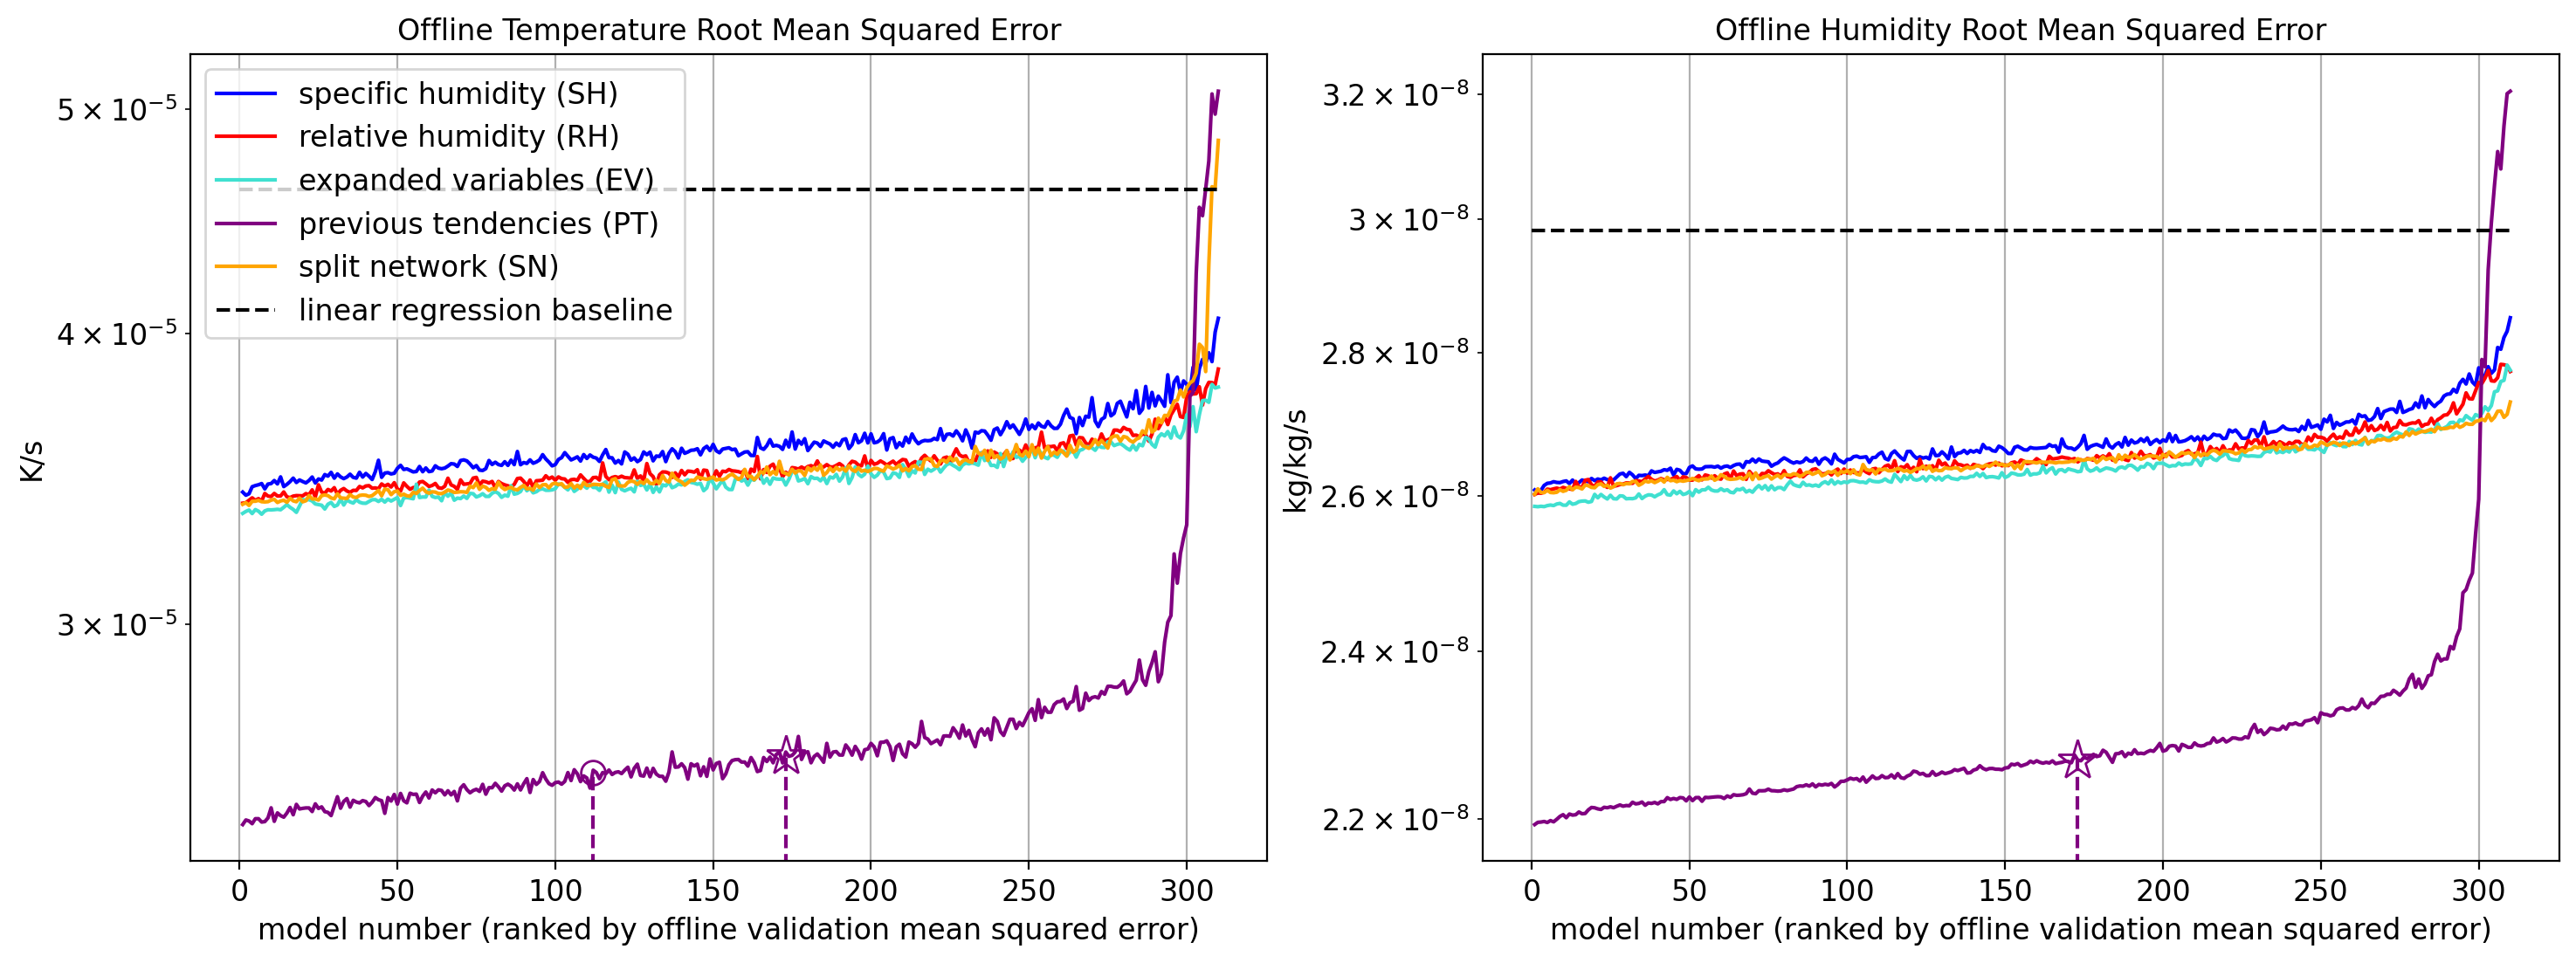

In [20]:
endmag = 310
fig, ax_ =  plt.subplots(ncols=2)

ax = ax_[0]
ax.set_yscale('log')
pd_proj_specific['offline_rmse_T'].iloc[0:endmag].plot(ax=ax, label="specific humidity (SH)", color = "blue")
pd_proj_relative['offline_rmse_T'].iloc[0:endmag].plot(ax=ax, label="relative humidity (RH)", color = "red")
pd_proj_expanded['offline_rmse_T'].iloc[0:endmag].plot(ax=ax, label="expanded variables (EV)", color = "turquoise")
pd_proj_previous['offline_rmse_T'].iloc[0:endmag].plot(ax=ax, label="previous tendencies (PT)", color = "purple")
pd_proj_split['offline_rmse_T'].iloc[0:endmag].plot(ax=ax, label="split network (SN)", color = "orange")
ax.plot([0,endmag],[offline_mlr_error_T, offline_mlr_error_T], label = "linear regression baseline", linestyle = '--', color = 'black')

ax.set_ylabel('K/s')
ax.set_xlabel('model number (ranked by offline validation mean squared error)')
ax.legend(loc = "upper left")
ax.plot(173, pd_proj_previous.iloc[173]['offline_rmse_T'], marker = "*", color = "purple", markersize = 17, markerfacecolor = 'none')
ax.plot([173,173],[0, pd_proj_previous.iloc[173]['offline_rmse_T']], linestyle = '--', color = "purple")
ax.plot(112, pd_proj_previous.iloc[112]['offline_rmse_T'], marker = "o", color = "purple", markersize = 10, markerfacecolor = 'none')
ax.plot([112,112],[0, pd_proj_previous.iloc[112]['offline_rmse_T']], linestyle = '--', color = "purple")
ax.set_xlabel('model number (ranked by offline validation mean squared error)')
ax.set_title("Offline Temperature Root Mean Squared Error", fontsize = 12)
ax.grid(True)

ax = ax_[1]
ax.set_yscale('log')
pd_proj_specific['offline_rmse_Q'].iloc[0:endmag].plot(ax=ax, label="specific humidity (SH)", color = "blue")
pd_proj_relative['offline_rmse_Q'].iloc[0:endmag].plot(ax=ax, label="relative humidity (RH)", color = "red")
pd_proj_expanded['offline_rmse_Q'].iloc[0:endmag].plot(ax=ax, label="expanded variables (EV)", color = "turquoise")
pd_proj_previous['offline_rmse_Q'].iloc[0:endmag].plot(ax=ax, label="previous tendencies (PT)", color = "purple")
pd_proj_split['offline_rmse_Q'].iloc[0:endmag].plot(ax=ax, label="split network (SN)", color = "orange")
ax.plot([0,endmag],[offline_mlr_error_Q, offline_mlr_error_Q], linestyle = '--', color = 'black')

ax.set_ylabel('kg/kg/s')
ax.set_xlabel('model number (ranked by offline validation mean squared error)')
ax.plot(173, pd_proj_previous.iloc[173]['offline_rmse_Q'], marker = "*", color = "purple", markersize = 17, markerfacecolor = 'none')
ax.plot([173,173],[0, pd_proj_previous.iloc[173]['offline_rmse_Q']], linestyle = '--', color = "purple")
ax.set_xlabel('model number (ranked by offline validation mean squared error)')
ax.set_title("Offline Humidity Root Mean Squared Error", fontsize = 12)
ax.grid(True)

fig.set_size_inches(17.5,6)

Text(0.5, 1.0, 'Online Humidity RMSE')

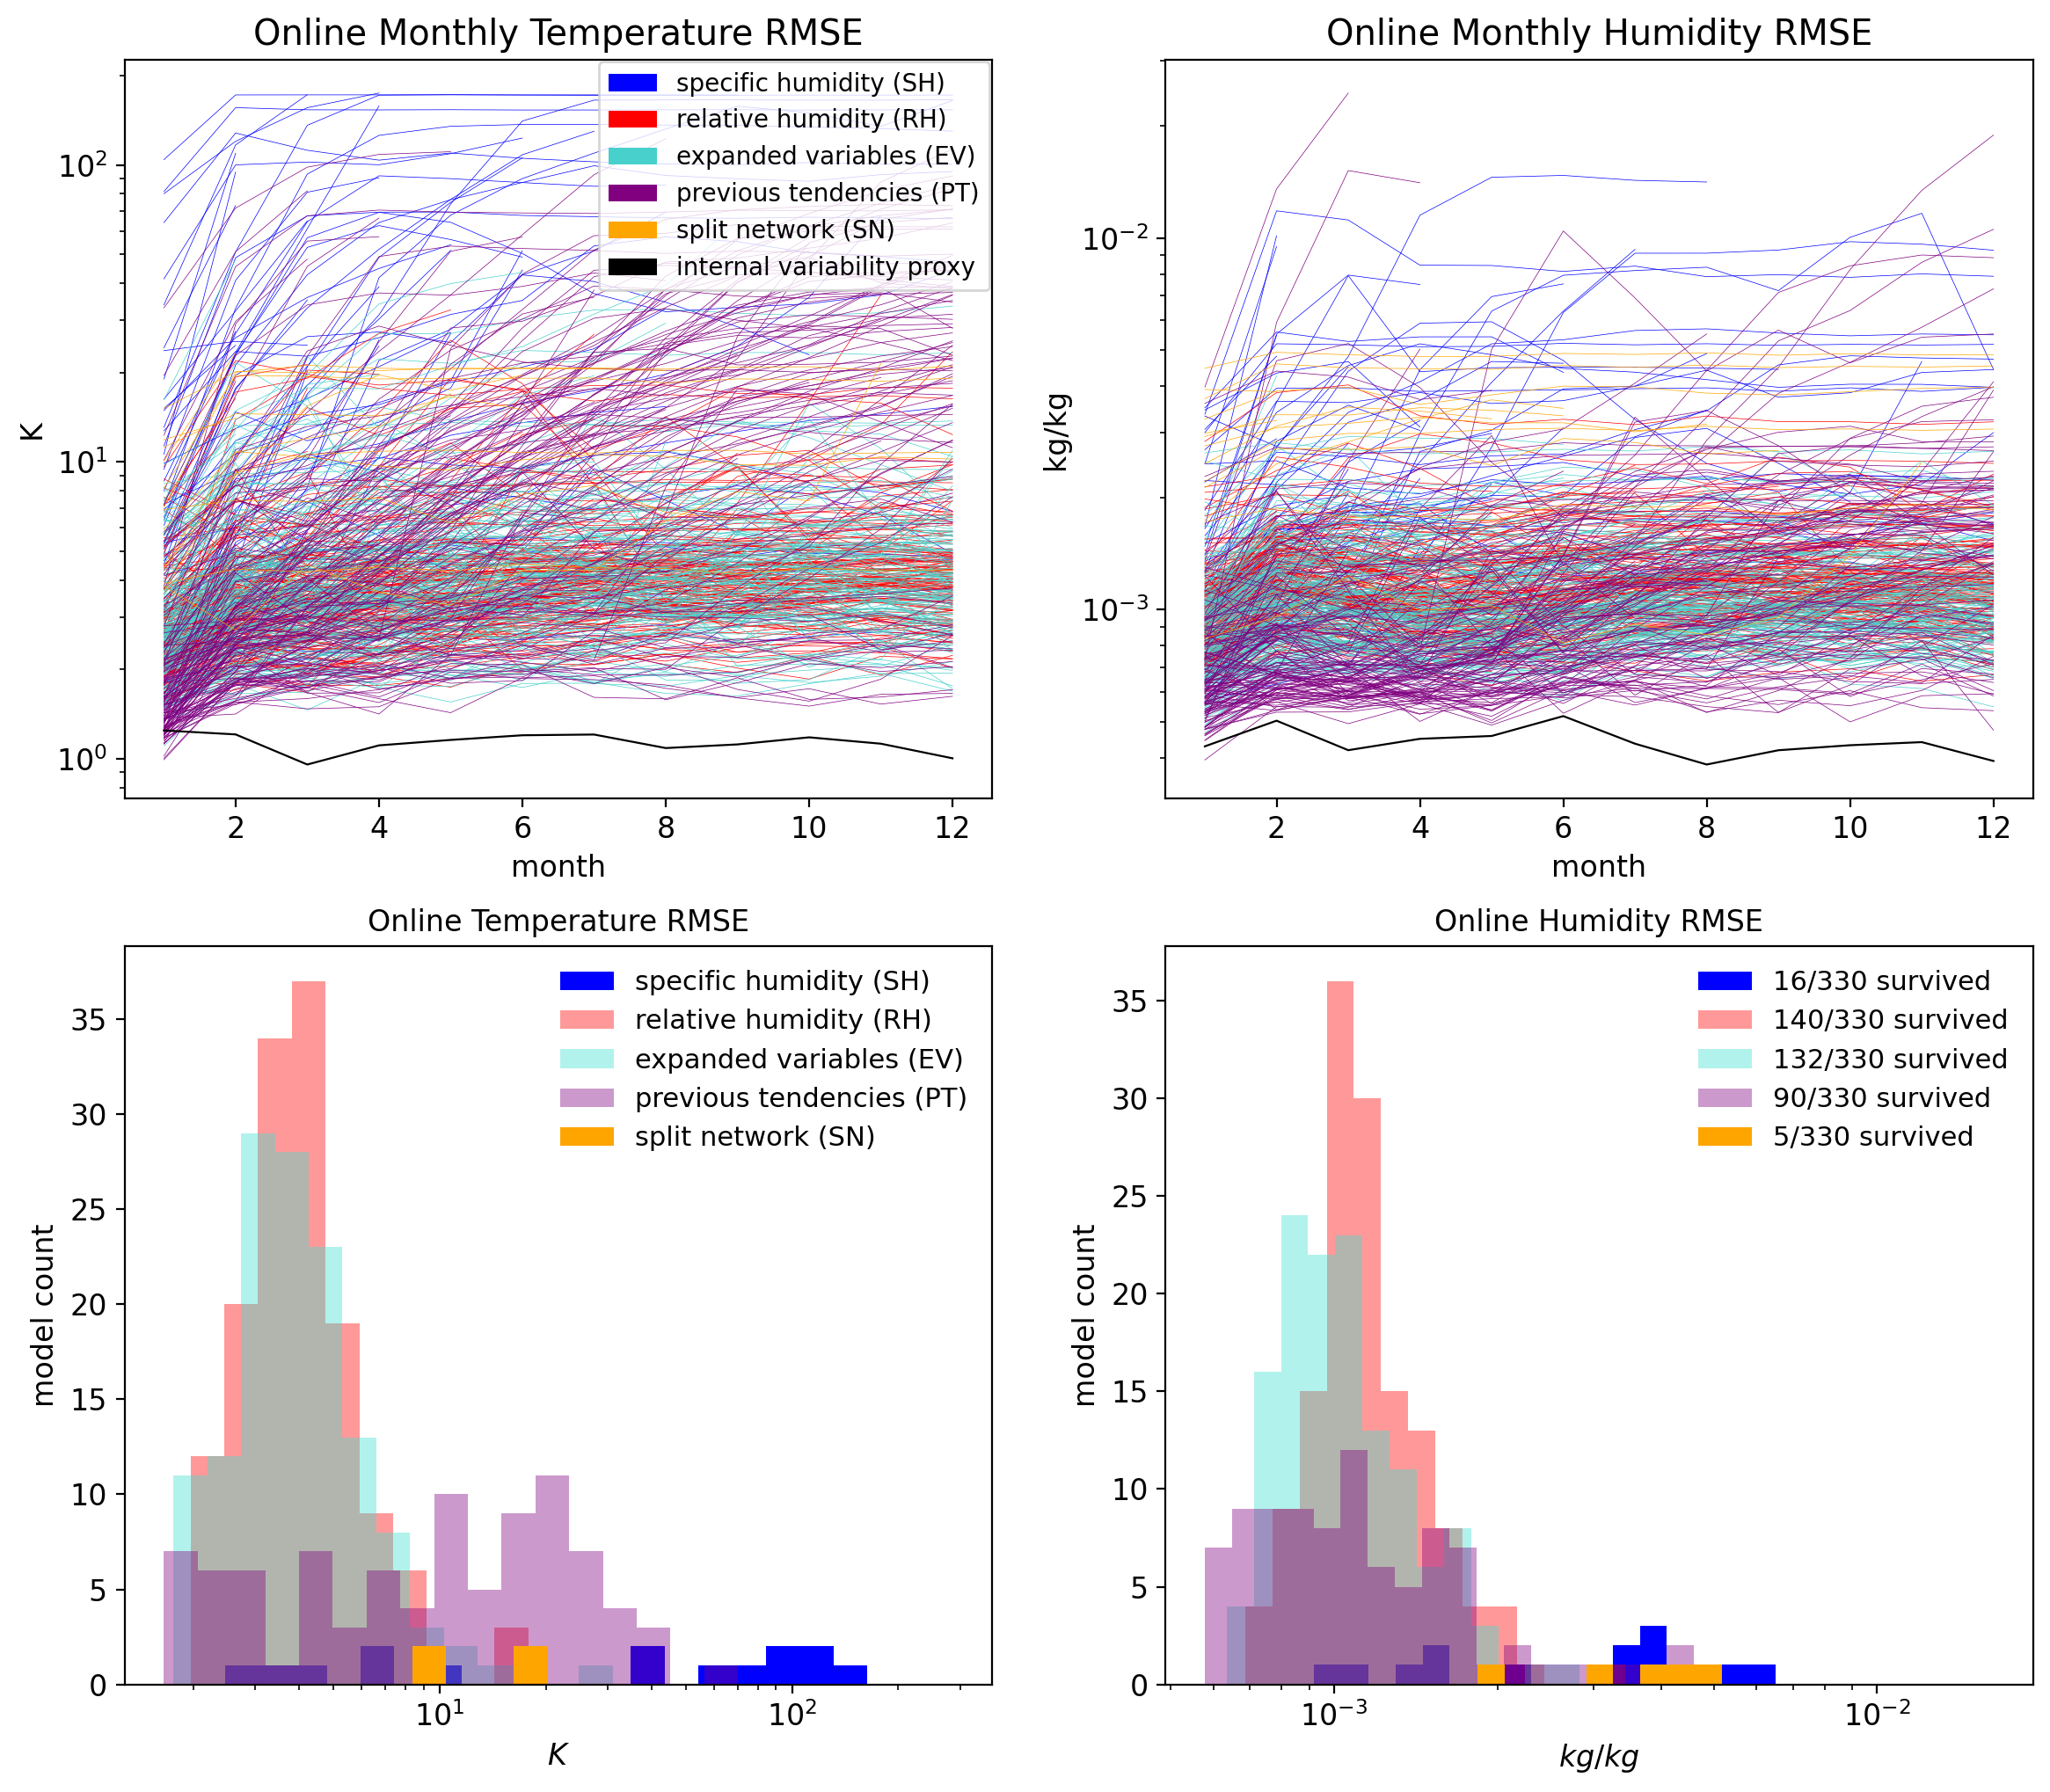

In [20]:
fig3 = plt.figure(figsize=(14,12))
myfontsize = 12

ax1 = fig3.add_subplot(2,2,1)
plotDiffs(ax1, [diff_T_specific, diff_T_relative, diff_T_expanded, diff_T_previous, diff_T_split], "NNTBP", \
          ["specific humidity (SH)", "relative humidity (RH)", "expanded variables (EV)", "previous tendencies (PT)", "split network (SN)"])

ax2 = fig3.add_subplot(2,2,2)
plotDiffs(ax2, [diff_Q_specific, diff_Q_relative, diff_Q_expanded, diff_Q_previous, diff_Q_split], "NNQBP", \
          ["specific humidity (SH)", "relative humidity (RH)", "expanded variables (EV)", "previous tendencies (PT)", "split network (SN)"], 
          show_legend = False)

ax3 = fig3.add_subplot(2,2,3) # (rows, cols, plots)
ax3.set_xscale("log")

def create_logspace(min_val, log10_diff, num):
    return np.logspace(np.log10(min_val), np.log10(min_val) + log10_diff, num = num)

logbins_temp_specific = create_logspace(full_year_specific["online_rmse_T"].min(), log10_diff = 1.82, num = 20)
logbins_temp_relative = create_logspace(full_year_relative["online_rmse_T"].min(), log10_diff = 1.82, num = 20)
logbins_temp_expanded = create_logspace(full_year_expanded["online_rmse_T"].min(), log10_diff = 1.82, num = 20)
logbins_temp_previous = create_logspace(full_year_previous["online_rmse_T"].min(), log10_diff = 1.82, num = 20)
logbins_temp_split = create_logspace(full_year_split["online_rmse_T"].min(), log10_diff = 1.82, num = 20)

ax3.hist(full_year_specific["online_rmse_T"], density = False, bins = logbins_temp_specific, color = "blue")
ax3.hist(full_year_relative["online_rmse_T"], density = False, bins = logbins_temp_relative, color = "red", alpha = .4)
ax3.hist(full_year_expanded["online_rmse_T"], density = False, bins = logbins_temp_expanded, color = "turquoise", alpha = .4)
ax3.hist(full_year_previous["online_rmse_T"], density = False, bins = logbins_temp_previous, color = "purple", alpha = .4)
ax3.hist(full_year_split["online_rmse_T"], density = False, bins = logbins_temp_split, color = "orange")
ax3.legend(["specific humidity (SH)", "relative humidity (RH)", "expanded variables (EV)", "previous tendencies (PT)", "split network (SN)"], frameon = False, fontsize = 11)
ax3.set_xlabel("$K$", fontsize = myfontsize)
ax3.set_ylabel("model count", fontsize = myfontsize)
ax3.set_title("Online Temperature RMSE", fontsize = myfontsize)

logbins_hum_specific = create_logspace(full_year_specific["online_rmse_Q"].min(), log10_diff = .95, num = 20)
logbins_hum_relative = create_logspace(full_year_relative["online_rmse_Q"].min(), log10_diff = .95, num = 20)
logbins_hum_expanded = create_logspace(full_year_expanded["online_rmse_Q"].min(), log10_diff = .95, num = 20)
logbins_hum_previous = create_logspace(full_year_previous["online_rmse_Q"].min(), log10_diff = .95, num = 20)
logbins_hum_split = create_logspace(full_year_split["online_rmse_Q"].min(), log10_diff = .95, num = 20)

ax4 = fig3.add_subplot(2,2,4)
ax4.set_xscale("log")
ax4.hist(full_year_specific["online_rmse_Q"], density = False, bins = logbins_hum_specific, color = "blue")
ax4.hist(full_year_relative["online_rmse_Q"], density = False, bins = logbins_hum_relative, color = "red", alpha = .4)
ax4.hist(full_year_expanded["online_rmse_Q"], density = False, bins = logbins_hum_expanded, color = "turquoise", alpha = .4)
ax4.hist(full_year_previous["online_rmse_Q"], density = False, bins = logbins_hum_previous, color = "purple", alpha = .4)
ax4.hist(full_year_split["online_rmse_Q"], density = False, bins = logbins_hum_split, color = "orange")
ax4.legend([str(len(full_year_specific)) + "/330 survived", 
            str(len(full_year_relative)) + "/330 survived", 
            str(len(full_year_expanded)) + "/330 survived",
            str(len(full_year_previous)) + "/330 survived",
            str(len(full_year_split)) + "/330 survived"], frameon = False, fontsize = 11)

ax4.set_xlabel("$kg/kg$", fontsize = myfontsize)
ax4.set_ylabel("model count", fontsize = myfontsize)
ax4.set_title("Online Humidity RMSE", fontsize = myfontsize)

# plt.subplots_adjust(0,0,2,1)

In [21]:
pd_proj_relative[(pd_proj_relative["online_rmse_T"]<2) & (pd_proj_relative["online_rmse_Q"]<0.001) & (pd_proj_relative["months_ran"]==12)]

,trial_id,leak,dropout,lr,hidden_units,num_layers,optimizer,batch_normalization,min_val_loss,total_hidden_nodes,offline_rmse_T,offline_rmse_Q,nps,months_ran,plotted,online_rmse_T,online_rmse_Q,offline_rmse_strato_T,offline_rmse_strato_Q
rank,,,,,,,,,,,,,,,,,,,
138,trial_282,0.232858,0.24721,0.000292,484,5,RAdam,False,0.001586,2420,0.000035,2.641983e-08,0.002493,12,True,1.965585,0.000874,0.000032,2.388323e-08


In [22]:
pd_proj_expanded[(pd_proj_expanded["online_rmse_T"]<2) & (pd_proj_expanded["online_rmse_Q"]<0.001) & (pd_proj_expanded["months_ran"]==12)]

,trial_id,leak,dropout,lr,hidden_units,num_layers,optimizer,batch_normalization,min_val_loss,total_hidden_nodes,offline_rmse_T,offline_rmse_Q,nps,months_ran,plotted,online_rmse_T,online_rmse_Q,offline_rmse_strato_T,offline_rmse_strato_Q
rank,,,,,,,,,,,,,,,,,,,
12,trial_079,0.228284,0.114360,0.000526,477,7,adam,True,0.001512,3339,0.000034,2.592235e-08,0.002824,12,True,1.760906,0.000802,0.000031,2.343351e-08
24,trial_315,0.228943,0.148437,0.000163,485,8,adam,True,0.001521,3880,0.000034,2.596156e-08,0.002892,12,True,1.940432,0.000723,0.000031,2.346896e-08
91,trial_227,0.197908,0.115863,0.000587,398,6,QHAdam,False,0.001550,2388,0.000034,2.613128e-08,0.002671,12,True,1.937630,0.000717,0.000031,2.362239e-08
99,trial_200,0.262237,0.052937,0.000979,405,7,QHAdam,False,0.001553,2835,0.000034,2.619204e-08,0.002557,12,True,1.985768,0.000836,0.000031,2.367732e-08
108,trial_148,0.126134,0.249126,0.000453,388,8,RAdam,True,0.001557,3104,0.000034,2.620092e-08,0.002488,12,True,1.991650,0.000679,0.000031,2.368535e-08


In [23]:
pd_proj_previous[(pd_proj_previous["online_rmse_T"]<2) & (pd_proj_previous["online_rmse_Q"]<0.001) & (pd_proj_previous["months_ran"]==12)]

,trial_id,leak,dropout,lr,hidden_units,num_layers,optimizer,batch_normalization,min_val_loss,total_hidden_nodes,offline_rmse_T,offline_rmse_Q,nps,months_ran,plotted,online_rmse_T,online_rmse_Q,offline_rmse_strato_T,offline_rmse_strato_Q
rank,,,,,,,,,,,,,,,,,,,
59,trial_143,0.089424,0.049840,0.000076,433,10,adam,False,0.001118,4330,0.000025,2.225755e-08,0.002769,12,True,1.764723,0.000868,0.000023,2.012062e-08
72,trial_256,0.048774,0.111396,0.000045,255,5,QHAdam,True,0.001125,1275,0.000025,2.232638e-08,0.002893,12,True,1.941797,0.000592,0.000023,2.018285e-08
107,trial_291,0.002189,0.043496,0.000139,130,8,QHAdam,True,0.001143,1040,0.000026,2.246062e-08,0.002920,12,True,1.966915,0.000655,0.000024,2.030420e-08
109,trial_283,0.037460,0.188732,0.000125,384,5,QHAdam,False,0.001144,1920,0.000026,2.246753e-08,0.002841,12,True,1.969925,0.000736,0.000024,2.031044e-08
112,trial_179,0.062770,0.249223,0.001605,489,8,RAdam,True,0.001145,3912,0.000026,2.247736e-08,0.003107,12,True,1.680304,0.000677,0.000024,2.031934e-08
173,trial_065,0.109191,0.219665,0.001633,416,10,adam,True,0.001171,4160,0.000026,2.268410e-08,0.003406,12,True,1.652284,0.000578,0.000024,2.050623e-08
193,trial_107,0.272477,0.184113,0.000209,310,10,QHAdam,False,0.001180,3100,0.000026,2.276399e-08,0.002603,12,True,1.954465,0.000735,0.000024,2.057845e-08


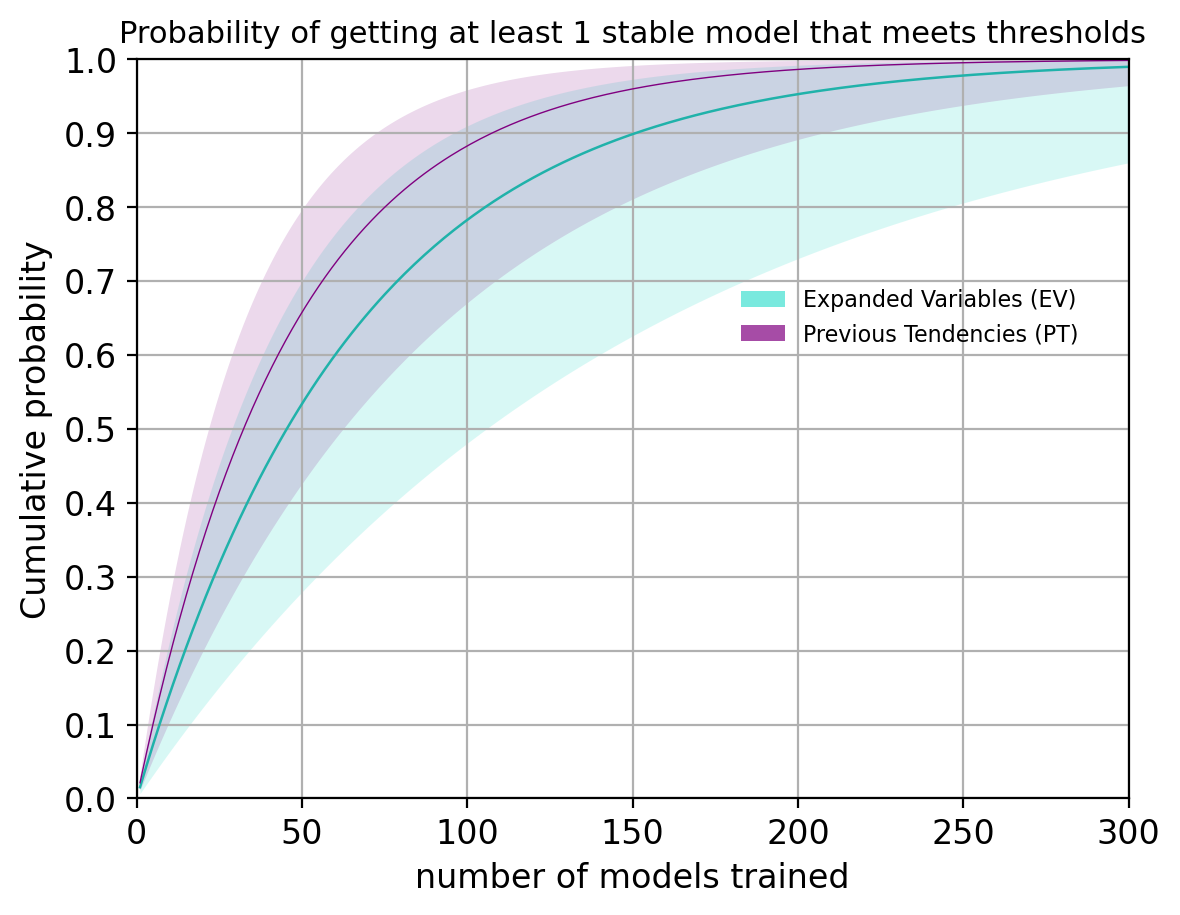

In [32]:
relative_success = pd_proj_relative[(pd_proj_relative["online_rmse_T"]<2) & (pd_proj_relative["online_rmse_Q"]<0.001) & (pd_proj_relative["months_ran"]==12)]
expanded_success = pd_proj_expanded[(pd_proj_expanded["online_rmse_T"]<2) & (pd_proj_expanded["online_rmse_Q"]<0.001) & (pd_proj_expanded["months_ran"]==12)]
previous_success = pd_proj_previous[(pd_proj_previous["online_rmse_T"]<2) & (pd_proj_previous["online_rmse_Q"]<0.001) & (pd_proj_previous["months_ran"]==12)]

xlen = 300

x = np.arange(1, xlen+1)  # generate values for x-axis
z = 1.282
# calculate CDF for each value of x

p_expanded = len(expanded_success)/330
p_previous = len(previous_success)/330

def getsd(p, z):
   return z*np.sqrt(p*(1-p)/330)

plt.plot(x, geom.cdf(x, p_expanded), color = "lightseagreen", linewidth = .9)
plt.fill_between(x, geom.cdf(x, p_expanded - getsd(p_expanded, z)), geom.cdf(x, p_expanded + getsd(p_expanded, z)), color = "turquoise", alpha=0.2, linewidth = .001)
plt.plot(x, geom.cdf(x, p_previous), color = "purple", linewidth = .5)  # plot CDF
plt.fill_between(x, geom.cdf(x, p_previous - getsd(p_previous, z)), geom.cdf(x, p_previous + getsd(p_previous, z)), color = "purple", alpha=0.15, linewidth = .001)

plt.xlabel('number of models trained')
plt.ylabel('Cumulative probability')
plt.title('Probability of getting at least 1 stable model that meets thresholds', fontsize = 11)
plt.legend(handles = [mpatches.Patch(facecolor = x, alpha = .7) for x in ["turquoise", "purple"]], \
            labels = ["Expanded Variables (EV)", "Previous Tendencies (PT)"], \
            loc = (.6, .6), \
            borderaxespad = 0.1, \
            fontsize = 8,
            frameon = False)

plt.grid(True)
plt.yticks([.1*x for x in range(11)])
plt.ylim(0,1)
plt.xlim(0,xlen)
plt.show()